# Import

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from GenerateNames import *
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
import pickle
from keras.layers import Input, Dense, Bidirectional, GRU, Embedding, Dropout, LSTM, Flatten,  Conv1D, MaxPooling1D, Activation
from keras.layers import concatenate, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras import regularizers, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve

warnings.filterwarnings("ignore", category=FutureWarning)

# Config

In [11]:
Name_length = 3
max_features = 5000
max_len = 30
labels ={"fake":1, "normal":0}
epochs=30
batch_size = 64

# Data Generator

## Normal Full Names

In [3]:
# GN = GenerateData(names_path = "Dataset/New_Names.csv", name_length=Name_length)
# GN.Generate_Normal(number_of_names=20000, saveto="Dataset/NormalFullNames.csv")
NormalNames = pd.read_csv("Dataset/NormalFullNames.csv")
NormalNames["label"] = labels["normal"]

## Fake Data

In [4]:
# GN.Generate_Fake_Names(number_of_names=20000, saveto="Dataset/FakeFullNames.csv")
FakeNames = pd.read_csv("Dataset/FakeFullNames.csv")
FakeNames["label"] = labels["fake"]

# Join and Train, Validation, Test split

In [5]:
Data = pd.concat([NormalNames, FakeNames], ignore_index=True)
Data = Data.sample(frac=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(Data.iloc[:,:-1], Data["label"], test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test.iloc[:,:-1], y_test, test_size=0.5, random_state=42)

In [7]:
print(f"Train size {len(X_train)}")
print(f"Valid size {len(X_valid)}")
print(f"Test size {len(X_test)}")

Train size 32000
Valid size 4000
Test size 4000


## visualise the length of names

In [8]:
X_train_nameslength = X_train.Name.apply(len)

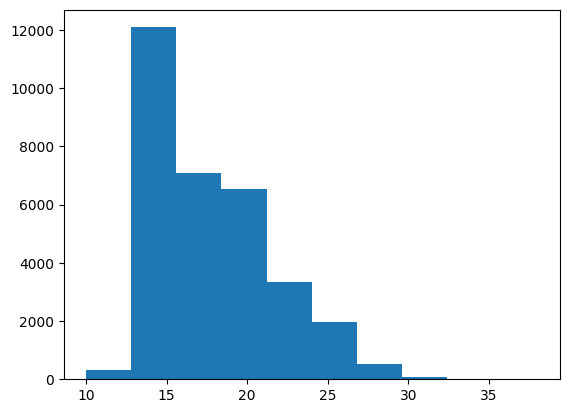

In [10]:
plt.hist(X_train_nameslength, bins=10)
plt.show()

## Tokenization

In [12]:
def Toknize_Text(data, maxlen, label=0, tokenizer=None, shuffle=False):
    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True)
    
    X = data.Name.values
    # Y = [label]*len(data) # 0: Real; 1: Fake

    if not tokenizer:
        # tokenizer = Tokenizer(num_words=max_features, oov_token='UNK')
        tokenizer = Tokenizer(num_words=None, char_level=True, oov_token='UNK')

        tokenizer.fit_on_texts(X)

    X = tokenizer.texts_to_sequences(X)
    X = pad_sequences(X, maxlen=maxlen, padding='post')

    return X, tokenizer

In [13]:
tk_Xtrain, tokenizer = Toknize_Text(X_train, max_len)
tk_Xvalid, _ = Toknize_Text(X_valid, max_len, tokenizer= tokenizer)
tk_Xtest, _ = Toknize_Text(X_test, max_len, tokenizer= tokenizer)

In [14]:
# Save the Toknizer
pickle.dump(tokenizer, open('results/tokenizer2.pkl', 'wb'))

# Model

## BiRNN

In [51]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Lmc = ModelCheckpoint('results/best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
Les = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [52]:
ClassificationModel = Sequential()
ClassificationModel.add(Input(shape=(max_len,)))
ClassificationModel.add(Embedding(max_features, 128))
ClassificationModel.add(Bidirectional(LSTM(256, return_sequences=True)))

ClassificationModel.add(Flatten())
ClassificationModel.add(Dense(1, activation='sigmoid'))
ClassificationModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
ClassificationModel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 30, 128)           640000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 30, 512)          788480    
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 15361     
                                                                 
Total params: 1,443,841
Trainable params: 1,443,841
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = ClassificationModel.fit(tk_Xtrain,
                         y_train,
                         validation_data=(tk_Xvalid, y_valid),
                         epochs=epochs,
                         batch_size=batch_size,
                         callbacks=[Les, Lmc],
                         verbose=1)

Epoch 1/30
500/500 [==============================] - ETA: 0s - loss: 0.2584 - accuracy: 0.8897
Epoch 1: val_loss improved from inf to 0.20515, saving model to results\best_model.h5
500/500 [==============================] - 232s 458ms/step - loss: 0.2584 - accuracy: 0.8897 - val_loss: 0.2052 - val_accuracy: 0.9195
Epoch 2/30
500/500 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.9461
Epoch 2: val_loss improved from 0.20515 to 0.10230, saving model to results\best_model.h5
500/500 [==============================] - 174s 349ms/step - loss: 0.1454 - accuracy: 0.9461 - val_loss: 0.1023 - val_accuracy: 0.9665
Epoch 3/30
500/500 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9678
Epoch 3: val_loss improved from 0.10230 to 0.08755, saving model to results\best_model.h5
500/500 [==============================] - 183s 365ms/step - loss: 0.0998 - accuracy: 0.9678 - val_loss: 0.0875 - val_accuracy: 0.9750
Epoch 4/30
500/500 [=====================

In [54]:
ClassificationModel.save('results/ClassificationModel.h5')

## Select the threshould

In [110]:
X_test_pre = ClassificationModel.predict(tk_Xtest)

125/125 [==============================] - 11s 86ms/step


In [111]:
precision, recall, thresholds = precision_recall_curve(y_test, X_test_pre)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))



Best Threshold=0.373775, F-Score=0.986


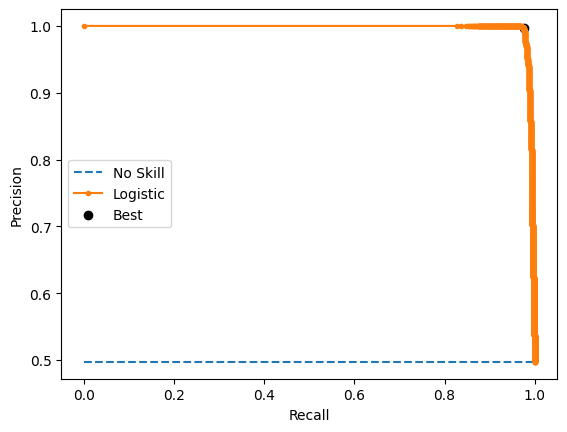

In [112]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

## Evaluation

In [55]:
def PLot_Model_Results(history,Title,Acc=True,metric="accuracy"):
    """plot Model accuracy and losse over epochs 
        Acc = True  plot Accuract garaph also
    """
    plt.figure(figsize=(10,6))

    if Acc==True:
        plt.plot(history.history[f'{metric}'])
        plt.plot(history.history[f'val_{metric}'])
        plt.title(Title)
        plt.ylabel(f'{metric}')
        plt.xlabel('epoch')
        plt.legend([f'train {metric}', f'validation {metric}'], loc='upper left')
        plt.show()
    else :
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(Title)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train loss', 'test loss'], loc='upper left')
        plt.show()

In [56]:
def plot_confusion_Matrix(y_true, y_predict, plottitle, labels):

    #Create confusion matrix and normalizes it over predicted (columns)
    result = confusion_matrix(y_true, y_predict)
    labels = list(dict(sorted(labels.items(), key=lambda item: item[1])).keys())
    df_cm = pd.DataFrame(result, index = [i for i in labels],
                  columns = [i for i in labels])
    plt.figure(figsize = (10,7))
    plt.title(plottitle)
    s = sns.heatmap(df_cm, annot=True, fmt='g')
    s.set(xlabel='Actual', ylabel='Predicted')
    plt.show()

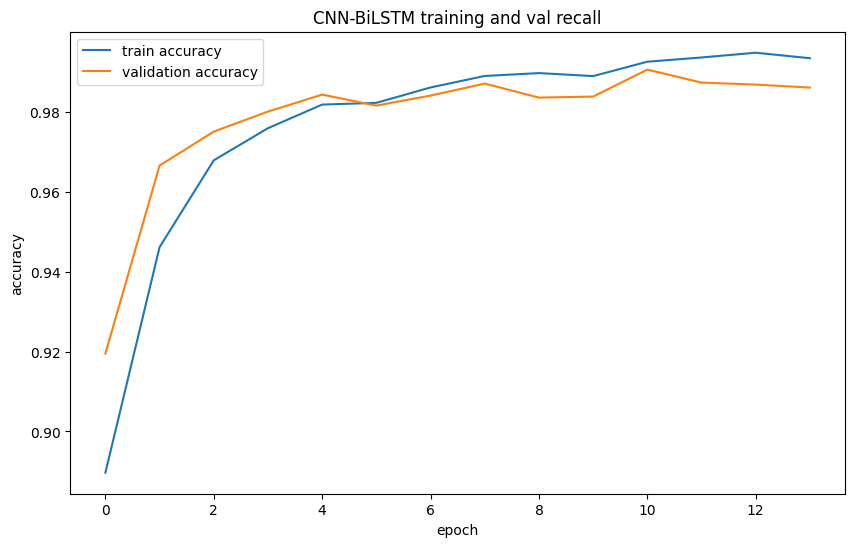

In [57]:
PLot_Model_Results(history , "CNN-BiLSTM training and val recall",True,"accuracy")


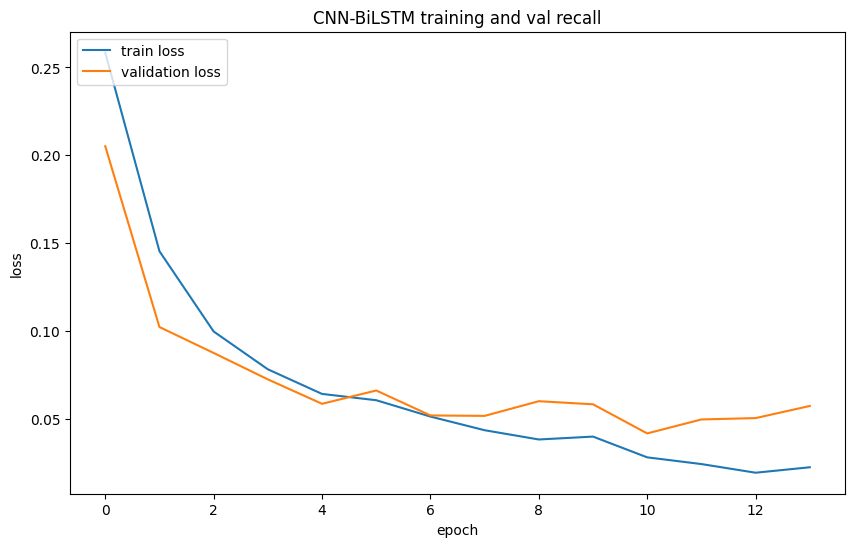

In [58]:
PLot_Model_Results(history , "CNN-BiLSTM training and val recall",True,"loss")


### Confusion Matrix

In [117]:
# X_test_pre = ClassificationModel.predict(tk_Xtest)
X_test_pre[X_test_pre >= thresholds[ix]] = 1
X_test_pre[X_test_pre < thresholds[ix]] = 0

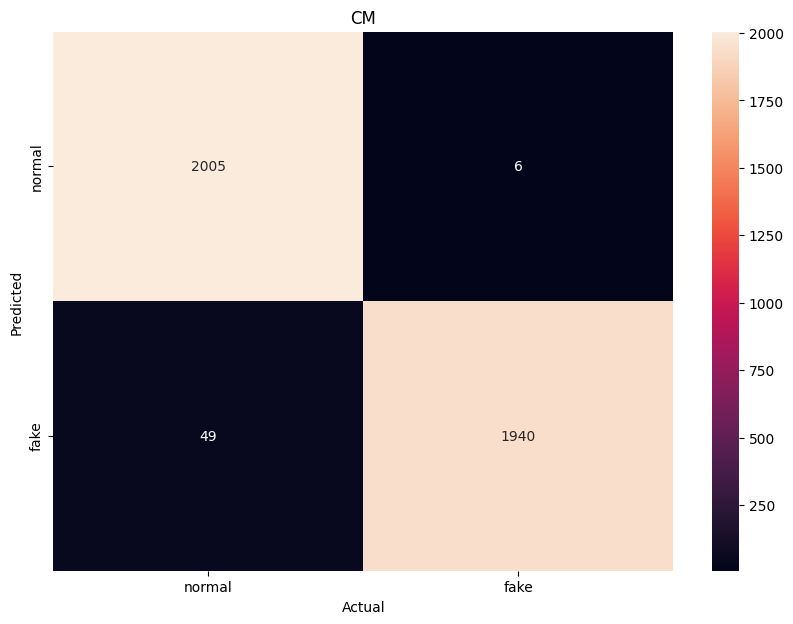

In [118]:
plot_confusion_Matrix(y_test, X_test_pre, "CM", labels)

### Classification Report

In [119]:
labels_names = list(dict(sorted(labels.items(), key=lambda item: item[1])).keys())

In [120]:
print(classification_report(y_test, X_test_pre, target_names= labels_names))

              precision    recall  f1-score   support

      normal       0.98      1.00      0.99      2011
        fake       1.00      0.98      0.99      1989

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000

